In [3]:
import numpy as np
from lab.classifiers.kfingerprinting import ALL_DEFAULT_FEATURES
from pathlib import Path
import pathlib
import pandas as pd
import json
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from lab import tracev2

DIRECTORY = f"../../results/debug/buflo-reg-client/"
# DIRECTORY = f"../../results/delay-vs-drop/tamaraw/delay.300mult/"
feature_names = np.array(ALL_DEFAULT_FEATURES)
# %matplotlib widget

In [4]:
with h5py.File(Path(DIRECTORY, "dataset.sim.h5"), mode="r") as h5in:
    classes = h5in["labels"]["class"]
    sizes = h5in["sizes"][:]

In [5]:
sizes_arr = np.zeros((len(sizes), max(len(x) for x in sizes)), dtype=int)
for i, arr in enumerate(sizes):
    sizes_arr[i, :len(arr)] = arr
sizes_arr

array([[ 750, -750,  750, ..., -750,  750, -750],
       [ 750, -750,  750, ..., -750,  750, -750],
       [ 750, -750,  750, ..., -750,  750, -750],
       ...,
       [ 750, -750,  750, ..., -750,  750, -750],
       [ 750, -750,  750, ..., -750,  750, -750],
       [ 750, -750,  750, ..., -750,  750, -750]])

In [6]:
frame = pd.DataFrame({"out": np.sum(sizes_arr > 0, axis=1),
                      "in": np.sum(sizes_arr < 0, axis=1),
                      "class": classes})
frame

,out,in,class
0,999,999,-1
1,999,999,-1
2,999,999,-1
3,999,999,-1
4,999,999,-1
...,...,...,...
195,999,999,0
196,999,999,0
197,999,999,0
198,999,999,0


In [7]:
p = frame.groupby(["out", "in"]).agg(["nunique", "size"])
p.groupby([("class", "nunique")]).sum()

,class
,size
"(class, nunique)",
2,200


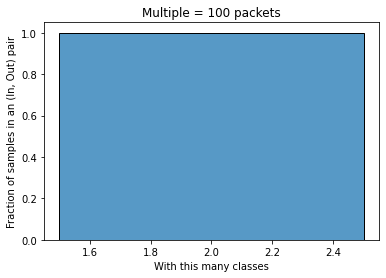

In [8]:
def plot_at_multiple(frame, multiple: int, ax=None, alt=False):
    ax = ax or plt.subplots()[1]
    
    frame = frame.copy()
    frame["out"] = frame["out"] + (multiple - (frame["out"] % multiple))
    frame["in"] = frame["in"] + (multiple - (frame["in"] % multiple))
    assert (frame[["in", "out"]] % multiple == 0).all().all()
    
    ax.set_title(f"Multiple = {multiple} packets")
    if not alt:
        plot_data = frame.groupby(["out", "in"]).nunique().squeeze()
        sns.histplot(x=plot_data, discrete=True, stat="probability", ax=ax)
        ax.set_ylabel("Fraction of Unique (In, Out) pairs")
        ax.set_xlabel("With this many classes having a sample within it")
    else:
        plot_data = frame.groupby(["out", "in"]).agg(["nunique", "size"])
        plot_data = plot_data.groupby([("class", "nunique")]).sum().reset_index()
        sns.histplot(x=plot_data[("class", "nunique")], weights=plot_data[("class", "size")], ax=ax, stat="probability", discrete=True)
        ax.set_ylabel("Fraction of samples in an (In, Out) pair")
        ax.set_xlabel("With this many classes")
    
plot_at_multiple(frame, 100, alt=True)


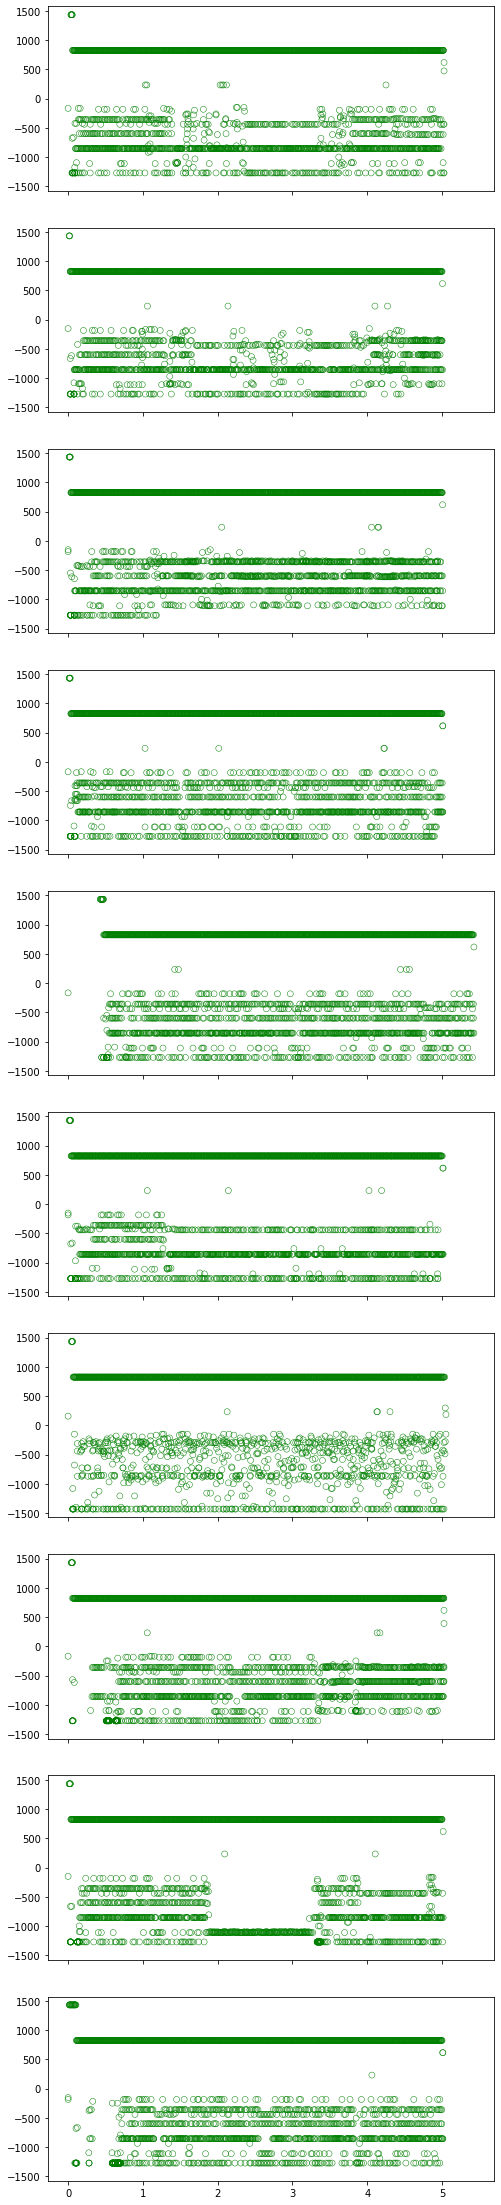

In [9]:
fig, ax = plt.subplots(10, 1, sharex=True, sharey=True, figsize=(8, 40))

with h5py.File(Path(DIRECTORY, "dataset.filtered.h5"), mode="r") as h5file:
    for i in range(10):
        times = h5file["timestamps"][i]
        sizes = h5file["sizes"][i]
        
        sns.scatterplot(x=times, y=sizes, ax=ax[i], marker='o', edgecolor="green", facecolor="none")
        
        # ax[i].set_ylabel(f"ID {id_:04d}")
fig.savefig("/tmp/traces.jpg", bbox_inches="tight", dpi=150)

In [10]:
trace_data = pd.DataFrame(tracev2.from_csv(Path(DIRECTORY, "dataset", f"{id_:04d}", f"0_{region}", "trace.csv")))

fig, ax = plt.subplots(figsize=(30, 8))
sns.histplot(data=trace_data, x="time", y="size", binwidth=(0.100, 100), legend=True, ax=ax)

NameError: name 'id_' is not defined